# Preprocessing

## Imports

In [181]:
# Importing the basic libraries
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

# From brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

#
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

#
import matplotlib.pyplot as plt

#
import warnings 
warnings.filterwarnings("ignore")

In [182]:
df = pd.read_csv("raw_data/walmart.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [183]:
df.columns = [i.lower() for i in df.columns]

In [184]:
df

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [185]:
# Reworking the dates
df.date = pd.to_datetime(df.date)

df["weekday"] = df.date.dt.weekday
df["month"] = df.date.dt.month
df["year"] = df.date.dt.year

df.drop(["date"],axis=1,inplace=True)
target = "weekly_sales"
features = [i for i in df.columns if i != target]
original_df = df.copy()

df.head()

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         6435 non-null   int64  
 1   weekly_sales  6435 non-null   float64
 2   holiday_flag  6435 non-null   int64  
 3   temperature   6435 non-null   float64
 4   fuel_price    6435 non-null   float64
 5   cpi           6435 non-null   float64
 6   unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [187]:
df.nunique().sort_values()

holiday_flag       2
year               3
weekday            7
month             12
store             45
unemployment     349
fuel_price       892
cpi             2145
temperature     3528
weekly_sales    6435
dtype: int64

In [188]:
# Uniqueness of rows
unique_count = df[features].nunique().sort_values()

# Numerical and categorical features
numerical_features = []
categorical_features = []

for feature in features:
    if unique_count[feature] <= 45:
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

print("There are {} numerical & {} categorical features.".format(len(numerical_features),len(categorical_features)))

There are 4 numerical & 5 categorical features.


In [189]:
display(df.describe())

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


## EDA

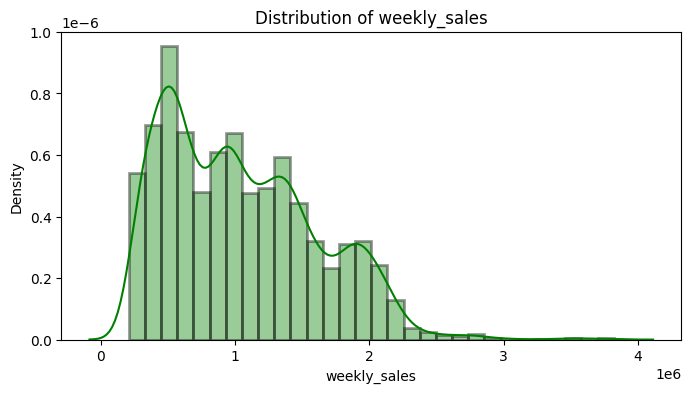

In [190]:
# Distribution of the target variable
fix, ax = plt.subplots(figsize=[8,4])
sns.distplot(df[target],color="g",hist_kws=dict(edgecolor="black",linewidth=2),bins=30)
plt.title("Distribution of weekly_sales")
plt.show()

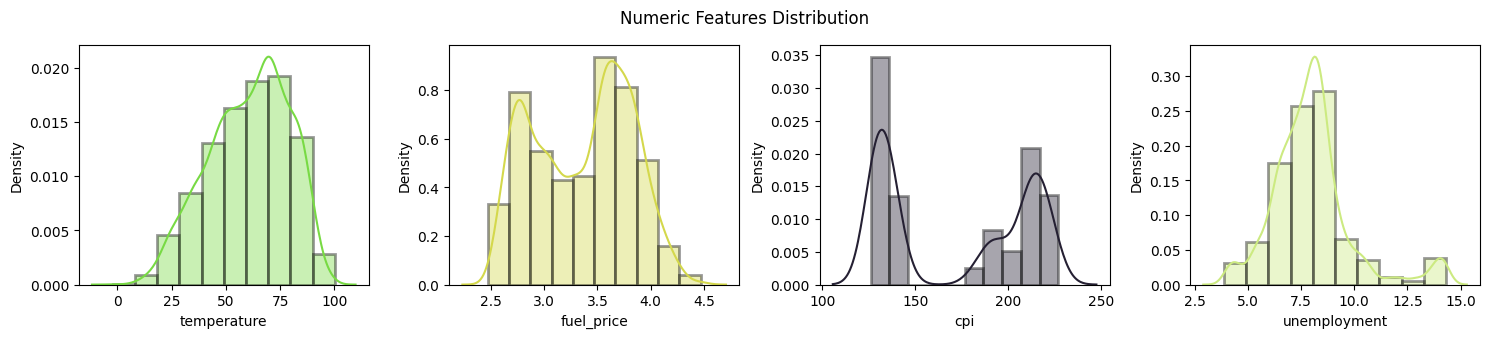

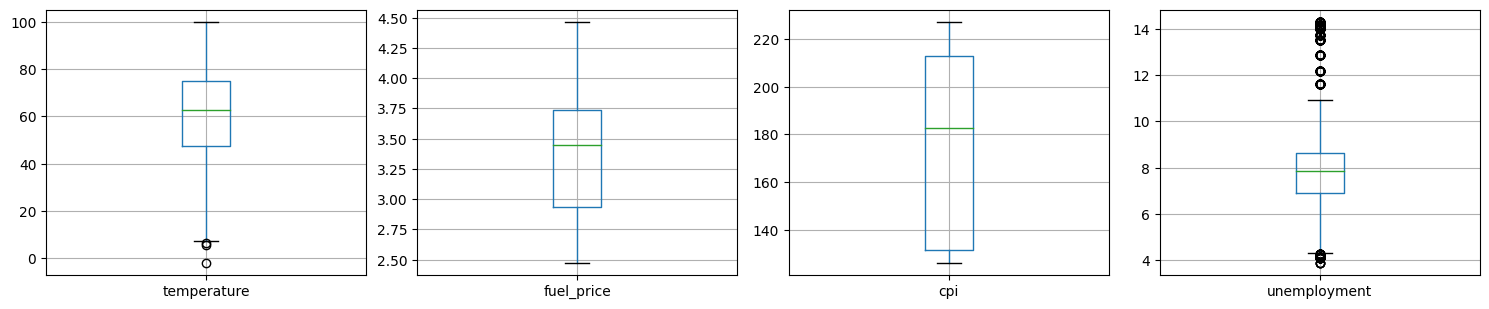

In [191]:
# Distribution of numeric features

n = 4
clr = ["r","g","b","g","b","r"]
plt.figure(figsize=[15,6*math.ceil(len(numerical_features)/n)])
plt.suptitle("Numeric Features Distribution")

for i in range(len(numerical_features)):
    plt.subplot(math.ceil(len(numerical_features)/3),n,i+1)
    sns.distplot(df[numerical_features[i]],hist_kws=dict(edgecolor="black",linewidth=2),bins=10,color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(numerical_features)/n)])
for i in range(len(numerical_features)):
    plt.subplot(math.ceil(len(numerical_features)/3),n,i+1)
    df.boxplot(numerical_features[i])
plt.tight_layout()
plt.show()

In [192]:
# # Understanding the relationship between all the features
# g = sns.pairplot(df)
# plt.title("Pairplots for all the Feature")
# g.map_upper(sns.kdeplot,levels=4,color=".2")
# plt.show()

## Data Preprocessing

In [193]:
# Removal of any duplicate rows (if any)
counter = 0
df.drop_duplicates(inplace=True)

if df.shape == original_df.shape:
    print("The dataset doesn\'t have any duplicates")
else:
    print(f"The number of duplicates dropped/fixed ---> {original_df.shape[0] - df.shape[0]}")

The dataset doesn't have any duplicates


In [194]:
# Check for empty elements
null_value_count = pd.DataFrame(df.isnull().sum().sort_values(),columns=["Total Null Values"])
null_value_count["Percentage"] = round(null_value_count["Total Null Values"]/df.shape[0],3)*100
null_value_count

,Total Null Values,Percentage
store,0,0.0
weekly_sales,0,0.0
holiday_flag,0,0.0
temperature,0,0.0
fuel_price,0,0.0
cpi,0,0.0
unemployment,0,0.0
weekday,0,0.0
month,0,0.0
year,0,0.0


In [195]:
df

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,4,9,2012
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,3,5,2012
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,0,12,2012
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,4,10,2012


In [196]:
# Converting categorical columns to numeric columns
df2 = df.copy()
features_with_null_values = null_value_count[null_value_count["Percentage"]!=0].index.values
categorical_features_no_null_values = [i for i in categorical_features if i not in features_with_null_values]

# One-Hot Binay Encoding
for i in categorical_features_no_null_values:
    if df2[i].nunique() == 2:
        print("One-Hot Encoding on feature --> ",i)
        df2[i] = pd.get_dummies(df2[i],drop_first=True,prefix=str(i))
    if (df2[i].nunique()>2):
        print("Dummy Encoding on feature --> ",i)
        df2=pd.concat([df2.drop([i],axis=1),pd.DataFrame(pd.get_dummies(df2[i],drop_first=True,prefix=str(i)))],axis=1)

print(df2.shape)
df2

Dummy Encoding on feature -->  store
One-Hot Encoding on feature -->  holiday_flag
Dummy Encoding on feature -->  weekday
Dummy Encoding on feature -->  month
Dummy Encoding on feature -->  year
(6435, 69)


,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,713173.95,0,64.88,3.997,192.013558,8.684,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6431,733455.07,0,64.89,3.985,192.170412,8.667,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
6432,734464.36,0,54.47,4.000,192.327265,8.667,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6433,718125.53,0,56.47,3.969,192.330854,8.667,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [197]:
# Removal of outliers
df3 = df2.copy()

for i in numerical_features:
    Q1 = df3[i].quantile(0.25)
    Q3 = df3[i].quantile(0.75)
    IQR = Q3 - Q1
    df3 = df3[df3[i] <= (Q3+(1.5*IQR))]
    df3 = df3[df3[i] >= (Q1-(1.5*IQR))]
    df3 = df3.reset_index(drop=True)

print("NOTE:")
print("Before removal of outliers,The dataset had {} samples.".format(df2.shape[0]))
print("After removal of outliers,The dataset now has {} samples.".format(df3.shape[0]))
display(df3)

NOTE:
Before removal of outliers,The dataset had 6435 samples.
After removal of outliers,The dataset now has 5951 samples.


,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,713173.95,0,64.88,3.997,192.013558,8.684,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5947,733455.07,0,64.89,3.985,192.170412,8.667,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5948,734464.36,0,54.47,4.000,192.327265,8.667,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5949,718125.53,0,56.47,3.969,192.330854,8.667,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [198]:
# Final dataset size after preprocessing
df = df3.copy()
df.columns = [i.replace("-","_") for i in df.columns]

number_of_dropped_rows = original_df.shape[0]-df.shape[0]
percentage_of_dropped_rows = (number_of_dropped_rows/original_df.shape[0]) * 100
percentage_of_dropped_rows = round(percentage_of_dropped_rows,2)

print("NOTE:")
print(f"After cleaning, {number_of_dropped_rows} or {percentage_of_dropped_rows}% of the samples were dropped.")
display(df)

NOTE:
After cleaning, 484 or 7.52% of the samples were dropped.


,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,713173.95,0,64.88,3.997,192.013558,8.684,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5947,733455.07,0,64.89,3.985,192.170412,8.667,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5948,734464.36,0,54.47,4.000,192.327265,8.667,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5949,718125.53,0,56.47,3.969,192.330854,8.667,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


## Splitting and Standardization

In [199]:
# Training and testing sets
X = df.drop(target,axis=1)
Y = df[target]
Train_X,Test_X,Train_Y,Test_Y = train_test_split(X,Y,train_size=0.8,test_size=0.2,random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print("Original set  ---> ",X.shape,Y.shape,"\nTraining set  ---> ",Train_X.shape,Train_Y.shape,"\nTesting set   ---> ",Test_X.shape,"",Test_Y.shape)

Original set  --->  (5951, 68) (5951,) 
Training set  --->  (4760, 68) (4760,) 
Testing set   --->  (1191, 68)  (1191,)


In [200]:
# Standardization/scaling of features
std = StandardScaler()

print("Scaling on training set")
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std,columns=X.columns)
display(Train_X_std.describe())

print("\n","Scaling on test set")
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std,columns=X.columns)
display(Test_X_std.describe())

Scaling on training set


,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,store_6,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
count,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,...,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03,4.760000e+03
mean,-2.836200e-17,3.381049e-16,-2.573105e-16,-1.970413e-16,1.470346e-16,-2.612289e-17,2.612289e-17,-1.492737e-17,1.604692e-17,-2.239105e-17,...,2.985474e-18,-3.284021e-17,-3.731842e-17,4.478211e-18,8.956421e-18,7.463684e-18,-3.731842e-17,-4.179663e-17,-2.537653e-17,-8.060779e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.738200e-01,-2.765561e+00,-1.882567e+00,-1.253019e+00,-2.756102e+00,-1.538048e-01,-1.545189e-01,-1.479791e-01,-1.487187e-01,-1.580458e-01,...,-3.131121e-01,-3.012349e-01,-3.151304e-01,-3.028913e-01,-3.211365e-01,-3.235192e-01,-2.551769e-01,-2.890363e-01,-7.573333e-01,-6.389711e-01
25%,-2.738200e-01,-7.381554e-01,-9.805747e-01,-1.081047e+00,-6.733832e-01,-1.538048e-01,-1.545189e-01,-1.479791e-01,-1.487187e-01,-1.580458e-01,...,-3.131121e-01,-3.012349e-01,-3.151304e-01,-3.028913e-01,-3.211365e-01,-3.235192e-01,-2.551769e-01,-2.890363e-01,-7.573333e-01,-6.389711e-01
50%,-2.738200e-01,1.104625e-01,1.676130e-01,3.832999e-01,1.014883e-01,-1.538048e-01,-1.545189e-01,-1.479791e-01,-1.487187e-01,-1.580458e-01,...,-3.131121e-01,-3.012349e-01,-3.151304e-01,-3.028913e-01,-3.211365e-01,-3.235192e-01,-2.551769e-01,-2.890363e-01,-7.573333e-01,-6.389711e-01
75%,-2.738200e-01,7.716204e-01,8.364814e-01,9.915222e-01,6.191444e-01,-1.538048e-01,-1.545189e-01,-1.479791e-01,-1.487187e-01,-1.580458e-01,...,-3.131121e-01,-3.012349e-01,-3.151304e-01,-3.028913e-01,-3.211365e-01,-3.235192e-01,-2.551769e-01,-2.890363e-01,1.320423e+00,1.565016e+00
max,3.652034e+00,2.180435e+00,2.466167e+00,1.338949e+00,2.580110e+00,6.501748e+00,6.471699e+00,6.757712e+00,6.724105e+00,6.327281e+00,...,3.193744e+00,3.319669e+00,3.173290e+00,3.301515e+00,3.113941e+00,3.091007e+00,3.918850e+00,3.459773e+00,1.320423e+00,1.565016e+00



 Scaling on test set


,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,store_6,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.009659,0.036099,0.037806,0.007451,-0.022689,0.030606,0.023515,-0.008822,0.082107,-0.011023,...,0.031390,-0.003293,0.021703,0.005798,-0.035601,-0.056894,0.042718,0.009987,0.020735,0.053129
std,1.016565,1.024013,0.982381,1.009229,1.009840,1.092864,1.071897,0.970776,1.238721,0.965741,...,1.044200,0.995430,1.030753,1.009063,0.948716,0.916524,1.075011,1.016087,1.006030,1.023355
min,-0.273820,-2.877436,-1.793239,-1.253019,-2.756102,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.313112,-0.301235,-0.315130,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,-0.757333,-0.638971
25%,-0.273820,-0.668574,-0.930464,-1.081222,-0.688300,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.313112,-0.301235,-0.315130,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,-0.757333,-0.638971
50%,-0.273820,0.163945,0.226439,0.384170,0.074074,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.313112,-0.301235,-0.315130,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,-0.757333,-0.638971
75%,-0.273820,0.846932,0.823409,1.012806,0.633658,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.313112,-0.301235,-0.315130,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,1.565016
max,3.652034,2.071834,2.466167,1.343977,2.580110,6.501748,6.471699,6.757712,6.724105,6.327281,...,3.193744,3.319669,3.173290,3.301515,3.113941,3.091007,3.918850,3.459773,1.320423,1.565016


## PCA

In [201]:
# # Checking the correlation
# print("Correlation matrix")
# fig,ax = plt.subplots(figsize=[25,20])
# sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,center=0) # cmap="BuGn"
# plt.show()

In [202]:
Train_Y

1348    1917397.63
743     2090268.95
5451     501780.66
489     1900246.47
3321     668390.82
           ...    
1890     583210.87
350      367405.40
79      1525147.09
3927     412385.75
5640     640159.04
Name: weekly_sales, Length: 4760, dtype: float64

In [203]:
Train_Y.reset_index()

,index,weekly_sales
0,1348,1917397.63
1,743,2090268.95
2,5451,501780.66
3,489,1900246.47
4,3321,668390.82
...,...,...
4755,1890,583210.87
4756,350,367405.40
4757,79,1525147.09
4758,3927,412385.75


In [204]:
Train_Y.reset_index(drop=True)

0       1917397.63
1       2090268.95
2        501780.66
3       1900246.47
4        668390.82
           ...    
4755     583210.87
4756     367405.40
4757    1525147.09
4758     412385.75
4759     640159.04
Name: weekly_sales, Length: 4760, dtype: float64

In [205]:
Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)

In [206]:
Train_xy

,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,store_6,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012,weekly_sales
0,-0.27382,1.387482,0.997707,-1.172478,0.428047,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,3.459773,1.320423,-0.638971,1917397.63
1,-0.27382,-0.433635,-1.017613,0.976518,-0.579850,-0.153805,-0.154519,-0.147979,-0.148719,6.327281,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,3.459773,-0.757333,-0.638971,2090268.95
2,-0.27382,1.664716,1.026030,-1.175951,0.619144,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,3.319669,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,-0.638971,501780.66
3,-0.27382,-0.174411,0.402915,-1.184842,-1.435354,-0.153805,-0.154519,6.757712,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,-0.638971,1900246.47
4,-0.27382,0.793177,1.073962,0.867124,-0.364563,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.301235,3.17329,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,-0.638971,668390.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755,-0.27382,-0.122566,-1.067724,-1.080952,0.300649,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,3.113941,-0.323519,-0.255177,-0.289036,-0.757333,-0.638971,583210.87
4756,-0.27382,1.009834,1.032567,1.133247,-0.122668,-0.153805,6.471699,-0.147979,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,-0.638971,367405.40
4757,-0.27382,1.668536,0.657826,1.045512,0.190183,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,3.459773,1.320423,-0.638971,1525147.09
4758,-0.27382,-0.625734,-0.357460,1.116188,-0.229908,-0.153805,-0.154519,-0.147979,-0.148719,-0.158046,...,-0.301235,-0.31513,-0.302891,-0.321136,-0.323519,-0.255177,-0.289036,1.320423,-0.638971,412385.75


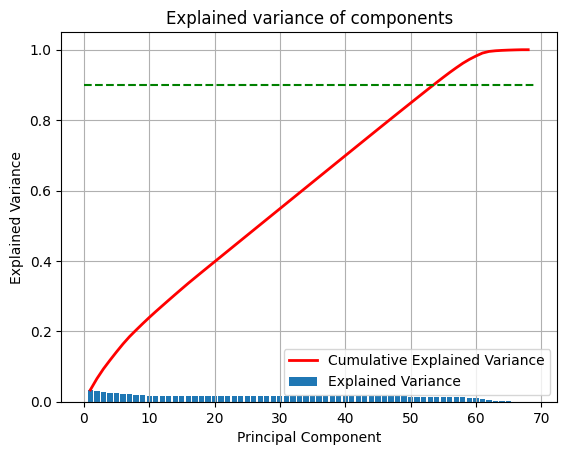

In [207]:
pca = PCA().fit(Train_X_std)

fig,ax = plt.subplots()
x_values = range(1,pca.n_components_+1)
ax.bar(x_values,pca.explained_variance_ratio_,lw=2,label="Explained Variance")
ax.plot(x_values,np.cumsum(pca.explained_variance_ratio_),lw=2,label="Cumulative Explained Variance",color="red")
plt.plot([0,pca.n_components_+1],[0.9,0.9],"g--")

ax.set_title("Explained variance of components")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")

plt.legend()
plt.grid()
plt.show()

In [208]:
pca.n_components_, X.shape, pca.explained_variance_ratio_.shape

(68, (5951, 68), (68,))

In [209]:
np.cumsum(pca.explained_variance_ratio_).shape

(68,)

In [210]:
df

,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,store_2,store_3,store_4,store_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2011,year_2012
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,713173.95,0,64.88,3.997,192.013558,8.684,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5947,733455.07,0,64.89,3.985,192.170412,8.667,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
5948,734464.36,0,54.47,4.000,192.327265,8.667,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5949,718125.53,0,56.47,3.969,192.330854,8.667,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


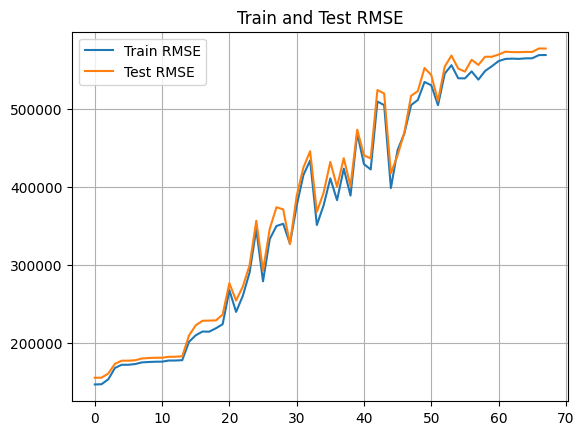

In [211]:
training_errors = []
test_errors = []

column_count = Train_X_std.shape[1]

for i in range(column_count):
    pca = PCA(n_components=column_count - i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    # Test_X_std_pca = pca.fit_transform(Test_X_std)
    Test_X_std_pca = pca.transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca,Train_Y)
    
    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)
    
    training_errors.append(round(np.sqrt(mean_squared_error(Train_Y,pred1)),2))
    test_errors.append(round(np.sqrt(mean_squared_error(Test_Y,pred2)),2))

plt.plot(training_errors,label="Train RMSE")
plt.plot(test_errors,label="Test RMSE")
plt.title("Train and Test RMSE")
plt.legend()
plt.grid()
plt.show()